In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [2]:
def get_direct_link(shared_link):
    return 'https://drive.google.com/uc?export=download&id=' + shared_link.split('/')[-2]

link = "https://drive.google.com/file/d/102W__aou_JelKysH04dAnr3FN9TFvaX0/view?usp=drive_link"

direct_link = get_direct_link(link)
df = pd.read_csv(direct_link)

In [3]:
df = df.sort_values(by='date')

split_index = int(0.75 * len(df))

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

test_df.reset_index(drop=True, inplace=True)

print('Fit set rows: '+str(len(train_df)))
print('Test set rows: '+str(len(test_df)))

Fit set rows: 2203
Test set rows: 735


In [4]:
train_df.date = pd.to_datetime(train_df.date, format='%Y-%m-%d')
train_df = train_df.sort_values(by='date')

test_df.date = pd.to_datetime(test_df.date, format='%Y-%m-%d')
test_df = test_df.sort_values(by='date')

In [5]:
def build_training_data(features):
    x = np.array(train_df[features])
    y = np.array(train_df['outcome'])
    x = sm.add_constant(x)
    x = x.astype(float)
    return x, y

def train_regression(features):
    x, y = build_training_data(features)
    model = sm.OLS(y, x).fit()
    return model.params

def train_model(wiki=True):
    features = ['inverse_odds']
    if wiki:
        features.append('wikibuzz')
    return train_regression(features)

def model_prob(coef, inv_odds, wikibuzz=None):
    y_hat = coef[0] + coef[1] * inv_odds
    if wikibuzz is not None:
        y_hat += coef[2] * wikibuzz
    return y_hat

def kelly(implied_prob, y):
    return max(y - ((1 - y) / ((1 / implied_prob) - 1)), 0)

def profit(stake, implied_prob, outcome):
    return stake * (1 / implied_prob - 1) if outcome == 1 else (-stake if outcome == 0 else 0)

def estimate_probabilities(data, coef, use_wiki=True):
    if use_wiki:
        data['est_prob'] = data.apply(lambda row: model_prob(coef, row['inverse_odds'], row['wikibuzz']), axis=1)
    else:
        data['est_prob'] = data.apply(lambda row: model_prob(coef, row['inverse_odds']), axis=1)
    return data

def show_results(data, coef, use_wiki=True):
    data = estimate_probabilities(data, coef, use_wiki)
    
    data['original_stake'] = [kelly(a, b) for a, b in zip(data['inverse_odds'], data['est_prob'])]
    data['original_profit'] = [profit(a, b, c) for a, b, c in zip(data['original_stake'], data['inverse_odds'], data['outcome'])]
    data['post-bet_balance'] = (data['original_profit'] + 1).cumprod()
    data['pre-bet_balance'] = data['post-bet_balance'].shift(1)
    data['correct_stake'] = data['original_stake'] * data['pre-bet_balance']
    data['correct_profit'] = data['original_profit'] * data['pre-bet_balance']
    
    results_summary = {
        'Bets considered (2 * Matches)': len(data[data['inverse_odds'].notna()]),
        'Number of bets placed': len(data[(data["original_profit"].notna()) & (data["original_profit"] != 0)]),
        'Mean overround (%)': ((data['inverse_odds'].mean() - 1) * 100),
        'Absolute amount bet': data['correct_stake'].sum(),
        'Absolute return': data['correct_profit'].sum(),
        'ROI (%)': ((((data['correct_profit'].sum() + data['correct_stake'].sum()) / data['correct_stake'].sum()) - 1) * 100)
    }
    
    print(results_summary)
    return results_summary

def plot_results(test_df):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)
    ax.set_title('Cumulative Profit Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(visible=True, linestyle='--', alpha=0.6)
    plt.show()

def plot_results_save(test_df, filename, title):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(visible=True, linestyle='--', alpha=0.6)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

{'Bets considered (2 * Matches)': 735, 'Number of bets placed': 193, 'Mean overround (%)': -47.712628932917866, 'Absolute amount bet': 7.233736072905033, 'Absolute return': -0.5562171427460743, 'ROI (%)': -7.689209796158625}


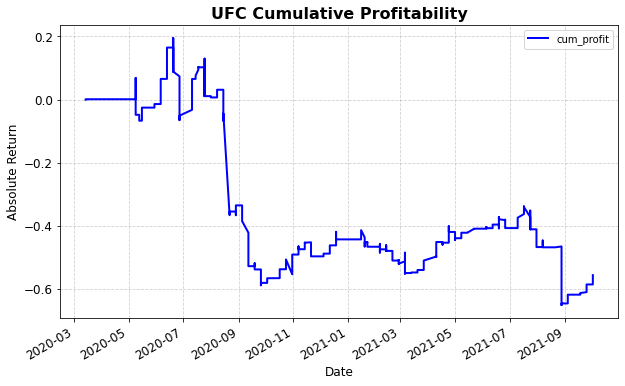

In [6]:
coef = train_model()
show_results(test_df, coef)
plot_results_save(test_df, 'UFC.png', "UFC Cumulative Profitability")

In [7]:
test_df.sort_values(by='correct_profit', ascending=True)

,match_id,fighter,date,wikibuzz,inverse_odds,Winner,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
173,2657,Timur Valiev,2020-08-22,2.390930,0.848485,Blue,0,0.899581,0.337233,-0.337233,0.633674,0.956105,0.322431,-0.322431,-0.366326
675,1765,Makhmud Muradov,2021-08-28,2.395070,0.851852,Blue,0,0.903368,0.347732,-0.347732,0.348685,0.534574,0.185889,-0.185889,-0.651315
129,2074,Nicolas Dalby,2020-07-25,1.748914,0.726027,Blue,0,0.754826,0.105115,-0.105115,1.011013,1.129768,0.118755,-0.118755,0.011013
9,54,Fabricio Werdum,2020-05-09,1.201570,0.767442,Red,0,0.792854,0.109273,-0.109273,0.951869,1.068643,0.116774,-0.116774,-0.048131
171,2456,Sean O'Malley,2020-08-15,1.171701,0.753086,Blue,0,0.776534,0.094962,-0.094962,0.933324,1.031254,0.097930,-0.097930,-0.066676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,2511,Song Yadong,2020-05-16,2.247513,0.666667,Red,1,0.696232,0.088695,0.044348,0.974601,0.933215,0.082772,0.041386,-0.025399
134,2051,Nathaniel Wood,2020-07-25,1.521042,0.819820,Red,1,0.855411,0.197529,0.043413,1.105563,1.059564,0.209295,0.045999,0.105563
23,2392,Ryan Spann,2020-05-09,1.951836,0.807692,Red,1,0.848141,0.210335,0.050080,1.051276,1.001139,0.210575,0.050137,0.051276
105,1522,Rose Namajunas,2020-07-11,4.569703,0.682540,Blue,1,0.746998,0.203043,0.094439,1.064454,0.972603,0.197480,0.091851,0.064454


In [8]:
filtered_df = test_df[(test_df['date'] >= '2020-08-01') & (test_df['date'] <= '2020-10-31')]
filtered_df.sort_values(by='correct_profit', ascending=True)

,match_id,fighter,date,wikibuzz,inverse_odds,Winner,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
173,2657,Timur Valiev,2020-08-22,2.390930,0.848485,Blue,0,0.899581,0.337233,-0.337233,0.633674,0.956105,0.322431,-0.322431,-0.366326
171,2456,Sean O'Malley,2020-08-15,1.171701,0.753086,Blue,0,0.776534,0.094962,-0.094962,0.933324,1.031254,0.097930,-0.097930,-0.066676
196,2365,Andrea Lee,2020-09-12,0.892702,0.770115,Red,0,0.791399,0.092585,-0.092585,0.504741,0.556241,0.051500,-0.051500,-0.495259
194,1949,Zelim Imadaev,2020-09-05,3.700714,0.528302,Red,0,0.563813,0.075284,-0.075284,0.614770,0.664821,0.050051,-0.050051,-0.385230
283,350,Bobby Green,2020-10-31,0.944462,0.770115,Blue,0,0.792139,0.095804,-0.095804,0.446266,0.493550,0.047284,-0.047284,-0.553734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2460,Sean Strickland,2020-10-31,1.598740,0.789474,Red,1,0.822924,0.158888,0.042370,0.508931,0.488244,0.077576,0.020687,-0.491069
170,1490,Jairzinho Rozenstruik,2020-08-15,1.703526,0.588477,Blue,1,0.601889,0.032591,0.022791,0.954596,0.933324,0.030418,0.021271,-0.045404
188,1286,Alexa Grasso,2020-08-29,1.307517,0.759036,Blue,1,0.785062,0.108009,0.034288,0.655455,0.633726,0.068448,0.021729,-0.344545
280,841,Dustin Jacoby,2020-10-31,1.847384,0.800000,Red,1,0.838132,0.190659,0.047665,0.488244,0.466031,0.088853,0.022213,-0.511756


In [9]:
test_df.loc[test_df.match_id == 2657]

,match_id,fighter,date,wikibuzz,inverse_odds,Winner,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
173,2657,Timur Valiev,2020-08-22,2.39093,0.848485,Blue,0,0.899581,0.337233,-0.337233,0.633674,0.956105,0.322431,-0.322431,-0.366326
176,2657,Trevin Jones,2020-08-22,-2.39093,0.205339,Blue,1,0.119175,0.000000,0.000000,0.645244,0.645244,0.000000,0.000000,-0.354756


In [10]:
test_df.wikibuzz.nlargest(10)

652    4.980287
105    4.569703
350    4.087554
135    3.716049
194    3.700714
150    3.580591
269    3.265396
515    3.264178
723    3.102136
448    3.048237
Name: wikibuzz, dtype: float64

# Without valiev

In [12]:
df = pd.read_csv(direct_link)

In [13]:
df = df.sort_values(by='date')

In [14]:
df.loc[df.fighter=='Timur Valiev']

,match_id,fighter,date,wikibuzz,inverse_odds,Winner,outcome
2376,2657,Timur Valiev,2020-08-22,2.390930,0.848485,Blue,0
2799,2230,Timur Valiev,2021-06-26,-0.834828,0.357143,Blue,1


In [15]:
df = df[df['match_id'] != 2657]

In [16]:
split_index = int(0.75 * len(df))

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

test_df.reset_index(drop=True, inplace=True)

print('Fit set rows: '+str(len(train_df)))
print('Test set rows: '+str(len(test_df)))

Fit set rows: 2202
Test set rows: 734


In [17]:
train_df.date = pd.to_datetime(train_df.date, format='%Y-%m-%d')
train_df = train_df.sort_values(by='date')

test_df.date = pd.to_datetime(test_df.date, format='%Y-%m-%d')
test_df = test_df.sort_values(by='date')

{'Bets considered (2 * Matches)': 734, 'Number of bets placed': 190, 'Mean overround (%)': -47.66905995174514, 'Absolute amount bet': 8.915418853054877, 'Absolute return': -0.3325706396244474, 'ROI (%)': -3.7302862053474106}


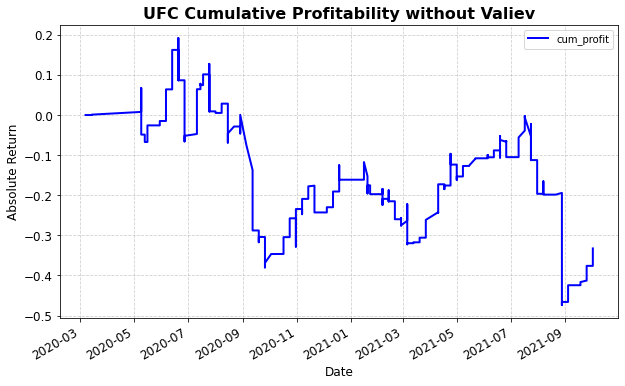

In [18]:
coef = train_model()
show_results(test_df, coef)
plot_results_save(test_df, 'UFC2.png', 'UFC Cumulative Profitability without Valiev')